### 1 - Definição do problema

Doenças cardiovasculares são a causa número 1 de mortes num contexto global. Representando 31% do total de mortes anuais
mundialmente.

Individuos que sofrem de doença cardiovascular ou estão em risco de sofrer (devido à presença de um ou mais fatores,
considerados de risco, como, hipertensão, diabetes, hiperlipidemia ou devido a outra doença), beneficiam de uma prematura
deteção e gestão para minimizar o risco de um agravamento de sintomas ou até manisfestação da doença.

Assim, é importante analisar dados clinicos de atuais pacientes e individous já considerados de risco, de maneira a
poder-se melhorar a capacidade de deteção de indícios da manisfestação da doença, por forma de melhor evitá-la ou pelo
menos mitigar os seus efeitos.

### 2 - Aquisição dos dados
Os dados utilizados para este trabalho foram retirados do Kaggle em https://www.kaggle.com/fedesoriano/heart-failure-prediction
e representam um agregado de conjuntos de dados clínicos de pacientes das seguintes instituições:

* Cleveland: 303 observations
* Hungarian: 294 observations
* Switzerland: 123 observations
* Long Beach VA: 200 observations
* Stalog (Heart) Data Set: 270 observations

E fornecidos por:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Estes dados já tinham sido anteriormente ligeiramente preparados, isto, é, já tinha sido feito uma remoção prévia de
dados duplicados.


## 3 - Data Wrangling

Nesta etapa as seguintes tarefas vão ser realizadas:
- Importar o dataset e fazer a limpeza de valores NaN (vazios)
- Renomear algumas colunas para melhor compreensão dos dados
- Converter nomenclaturas/abreviações para melhor processamento de dados
- Criar uma nova coluna de faixas etárias para agrupar os diferentes individuos
- Criar novas colunas indicando se os niveis de colestrol, batimento cardiacos
são normais, acima ou abaixo da média

Importar as bibliotecas que vão ser utilizadas

In [636]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from upsetplot import plot
import seaborn as sns
from math import ceil
sns.set()

Machine Learning algorithms

In [635]:
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # for confusion matrix
from sklearn.preprocessing import LabelEncoder

Importar o dataset

In [557]:
df = pd.read_csv('../data/heart.csv', sep=",", encoding="utf-8")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [558]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [559]:
df.drop_duplicates()
df.shape

(918, 12)

The dataset doesn't contain any nulls by default or duplicated values.

Vamos renomear algumas colunas para tornar os dados mais perceptiveis.

In [560]:
df = df.rename(columns={'Sex': 'Gender', 'FastingBS': 'Diabetes', 'MaxHR': 'MaxHeartRate', 'Oldpeak': 'STDeviation',})

In [561]:
# numeric value columns
metric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHeartRate', 'STDeviation']

Now lets take a look at the non-metric columns

In [562]:
categorical = ["Gender", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for value in categorical:
    print(df[value].value_counts(normalize=True), "\n")

M    0.78976
F    0.21024
Name: Gender, dtype: float64 

ASY    0.540305
NAP    0.221133
ATA    0.188453
TA     0.050109
Name: ChestPainType, dtype: float64 

Normal    0.601307
LVH       0.204793
ST        0.193900
Name: RestingECG, dtype: float64 

N    0.595861
Y    0.404139
Name: ExerciseAngina, dtype: float64 

Flat    0.501089
Up      0.430283
Down    0.068627
Name: ST_Slope, dtype: float64 



### Variables transformations

Since the column values seem to be specific categories, they can be converted in
numerical values to facilitate processing

In [563]:
enc = LabelEncoder()

# Gender: M -> 1 | F -> 0
enc.fit(df['Gender'])
df['Gender'] = enc.transform(df['Gender'])

# ChestPainType: ASY -> 0 | ATA -> 1 | NAP -> 2 | TA -> 3
enc.fit(df['ChestPainType'])
df['ChestPainType'] = enc.transform(df['ChestPainType'])

# RestingECG: LVH -> 0 | Normal -> 1 | ST -> 2
enc.fit(df['RestingECG'])
df['RestingECG'] = enc.transform(df['RestingECG'])

# ExerciseAngina: N -> 0 | Y -> 1
enc.fit(df['ExerciseAngina'])
df['ExerciseAngina'] = enc.transform(df['ExerciseAngina'])

# ST_Slope: Down -> 0 | Flat -> 1 | Up -> 2
enc.fit(df['ST_Slope'])
df['ST_Slope'] = enc.transform(df['ST_Slope'])

df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


##### Faixas etárias

Vamos categorizar as idades dos individuos no dataset, agrupando-os por faixas etárias
para melhor analisar os resultados dos dados clínicos destes.

In [564]:
df_extra_info = df.copy()
bins = np.arange(20, 100, 15)

df['AgeClass'] = np.digitize(df['Age'], bins, right=True)

Função génerica classificadora de dados como sendo altos, baixos ou normais.

Assim vai ser criada uma coluna onde os niveis de cada panciente estão classificados entre 'low', 'normal' e 'high'.


In [565]:
def f(row,col_name, min_value, high_value):
    if row[col_name] < min_value:
        val = 'Low'
    elif min_value < row[col_name] <= high_value:
        val = 'Normal'
    else:
        val = 'High'
    return val

##### Niveis de colestrol

O nivel de colestrol total para um adulto normal varia entre 125 a 200 mg/dL.

In [566]:
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

##### Niveis pressão sanguinea em repouso

O nivel de pressão sanguinea para um adulto normal varia entre 90/60mmHg e 120/80mmHg. Sendo considerada elevada quando
ultrapassa os 140/90mmHg.

In [567]:
df['RestingBPClass'] = df.apply(lambda row: f(row,'RestingBP', 90, 140) , axis=1)

##### Niveis máximos de batimentos cardiacos

Segundo, https://www.drjohnm.org/2011/08/whats-a-normal-heart-rate/
os niveis de batimentos cardiacos podem variar muito, pois estes são influenciados por diferentes fatores, como fatores
genéticos, hormonais, idade, historico de saúde, etc.

Para simplificação foi considerado que para um adulto normal, irião ser assumidos como um niveís normaais entre os
60 e os 100 batimentos/minuto.

In [568]:
df['MaxHeartRateClass'] = df.apply(lambda row: f(row,'MaxHeartRate', 90, 140) , axis=1)

Data set final após Data Wrangling.

In [569]:
df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease,AgeClass,CholesterolClass,RestingBPClass,MaxHeartRateClass
0,40,1,1,140,289,0,1,172,0,0.0,2,0,2,High,Normal,High
1,49,0,2,160,180,0,1,156,0,1.0,1,1,2,Normal,High,High
2,37,1,1,130,283,0,2,98,0,0.0,2,0,2,High,Normal,Normal
3,48,0,0,138,214,0,1,108,1,1.5,1,1,2,High,Normal,Normal
4,54,1,2,150,195,0,1,122,0,0.0,2,0,3,Normal,High,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1,2,High,Normal,Normal
914,68,1,0,144,193,1,1,141,0,3.4,1,1,4,Normal,High,High
915,57,1,0,130,131,0,1,115,1,1.2,1,1,3,Normal,Normal,Normal
916,57,0,1,130,236,0,0,174,0,0.0,1,1,3,High,Normal,High


## 4 - EDA

O EDA vai estar divido em três secções:
- Compreensão dos dados clínicos
- Análise por tabelas de valores (value_counts entre outros)
- Remoção de outliers
- Análise por grupos de dados

### Compriender os dados

#### restingECG
O ECG deteta os sinais elétricos do coração, uma vez que cada contração do músculo cardíaco ou das válvulas cardíacas
emite um impulso, este exame mede o tempo e a força dos impulsos elétricos.

Este teste pode ser feito de duas maneiras, em repouso (resting) ou em esforço/stress e providencia informação sobre o
batimento cardiaco e ritmo, podendo demonstrar se existe aumento do coração devido a uma elevada pressão sanguinea.

Por esse motivo, é o exame indicado para o despiste de arritmias cardíacas ou para a deteção
precoce de indicadores de isquemia cardíaca.

De notar que um resultado “normal” neste exame, não é suficiente para excluir uma doença
cardiovascular.

Nestes dados aparece como
* Normal
* ST - tendo onda ST segmentation anormal (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* LVH (left ventricular hipertrophy)

A presença de ST segmentation num ECG, deve-se a uma quebra no fluxo da corrente no grandiente de zonas isquémicas e
não-isquémicas, que afeta o fase de plateau, isto é, do potencial de ação transmembrana ventricular e por conseguinte
causa o ST segment.


#### ST Slope
Segundo, https://www.ncbi.nlm.nih.gov/books/NBK459364/
ST Slope or ST Segmentation é uma importante componente de um ECG e é, a forma que este pode tomar
acima (ST elevation) ou abaixo (ST depression) da linha de referência. Para além disso é importante caracterizar a
forma da onda do ST segment, pois este pode ser classificado como horizontal (flat), upsloping, ou downsloping
(sendo os últimos dois rápidos ou lentos) que são os dados presentes nesta
coluna.

Implicações destes fatores:
* A presença de uma ST elevation é uma causa comum para a deteção de fatores como LVH
* Em geral uma isquemia cardíaca é representada por uma ST depression, enquanto que uma lesão cardiáca pode ser indicada
por uma ST elevation
* É preciso ter em conta que nem todas as ST elevations ou ST depression representam isquemia cardíaca ou condições
emergentes, contudo multiplas condições estão associadas a estes fatores.

#### STDeviation

Está relacionada com a ocorrência de uma ST depression, representando as mudanças das ondas T, onde tanto para homens
como para mulheres os valores de referência são de -0.05 mV em V e -0.1 mV em todas as restantes.

Segundo, https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/
para quantificar as variações dos ST segments, calcula-se a variação em milimetros até ao ponto J da onda do ECG.

Assim, assume-se que os valores desta coluna, são dados em milemetros (mm) e que como está associada aos valores da
ST depression, valores, negativos, referem-se a medições de uma ST elevation.


#### ExerciseAngina

Angina é a dor que pode ocorrer durante a prática de exercício fisíco, stress ou outras coisas semelhantes que façam o
o coração trabalhar em esforço.

É um sintóma comum para doença na artéria coronária que pode ser causada artérias coronárias bloqueadas por colestrol.

#### Diabetes
É um indicador obtido através da colheita de sangue em jejum, feito normalmente, durante a noite.
Um nível inferior a 100 mg/dl é considerado normal, entre 100 e 125 mg/dl é indicador de pré-diabetes e acima disso
o paciente tem diabetes (geralmente fazem-se 2 testes diferentes para confirmar os resultos).

Neste dataset, estes valores são distinguidos entre ter diabetes (1) e não ter diabetes (0), ou seja, pacientes marcados
com “1” tinham valores acima de 120 mg/dl.


### Análise por tabelas de valores

In [570]:
df['Cholesterol'].value_counts(normalize=True)

0      0.187364
254    0.011983
223    0.010893
220    0.010893
230    0.009804
         ...   
392    0.001089
316    0.001089
153    0.001089
466    0.001089
131    0.001089
Name: Cholesterol, Length: 222, dtype: float64

Verifica-se que existem 172 pacientes com valor 0, o que em termos médicos não faria sentido registarem estes valores.

Uma vez que 172 pacientes representam 18% do dataset, a sua remoção poderia ter impactos negativos em futuras
análises. Assim ao invés de serem removidos optou-se por substituir estes valores pela mediana da coluna em questão.

In [571]:
df['Cholesterol'] = df['Cholesterol'].apply(lambda x: df['Cholesterol'].median() if x < 75 else x)
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

### Visualização de dados

#### histograms

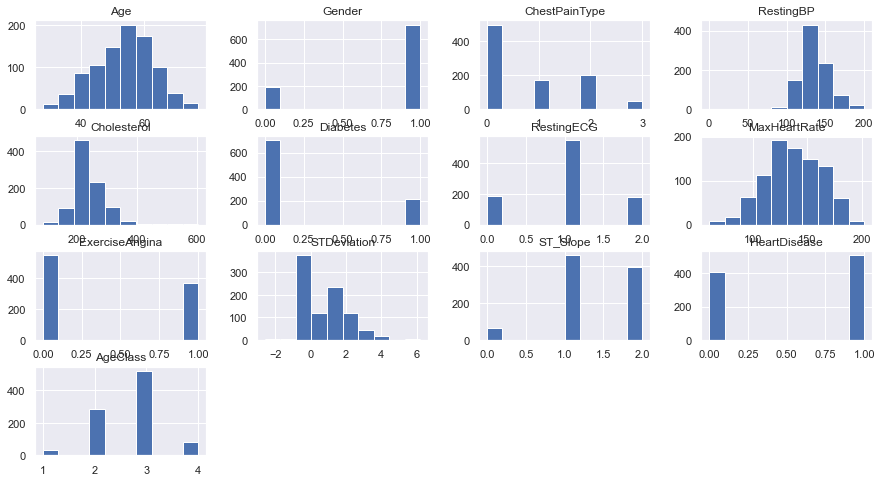

In [572]:
df.hist()
plt.show()

#### Heatmaps

<AxesSubplot:>

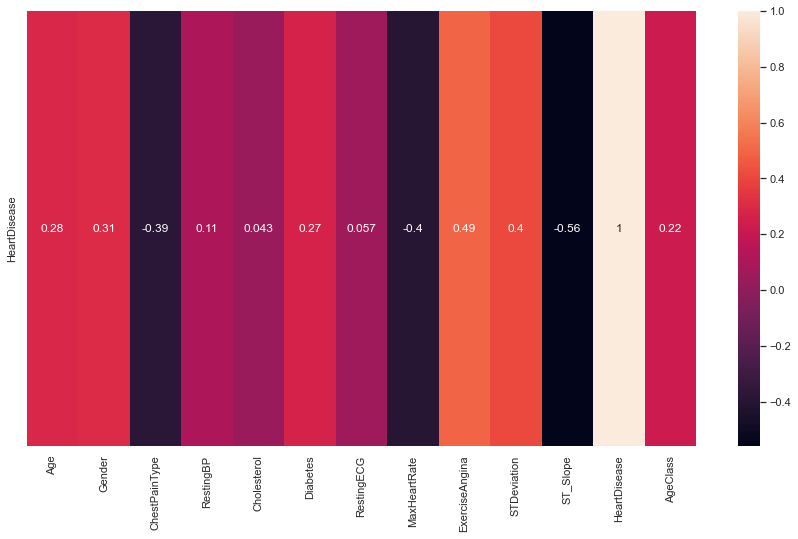

In [573]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=df.corr().loc[['HeartDisease']], annot=True)

Escrever conclusão sobre o gráfico

<AxesSubplot:>

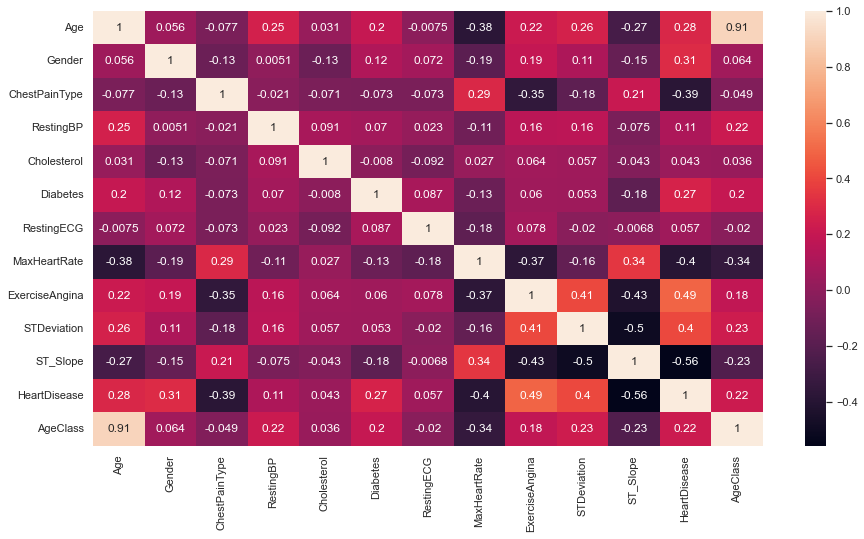

In [574]:
sns.heatmap(data=df.corr(), annot=True)

Parece que os dados não se correlacionam diretamente, apenas destacando-se uma ligeira correlação entre doenças de
coração e Angina durante exercício

#### Outliers

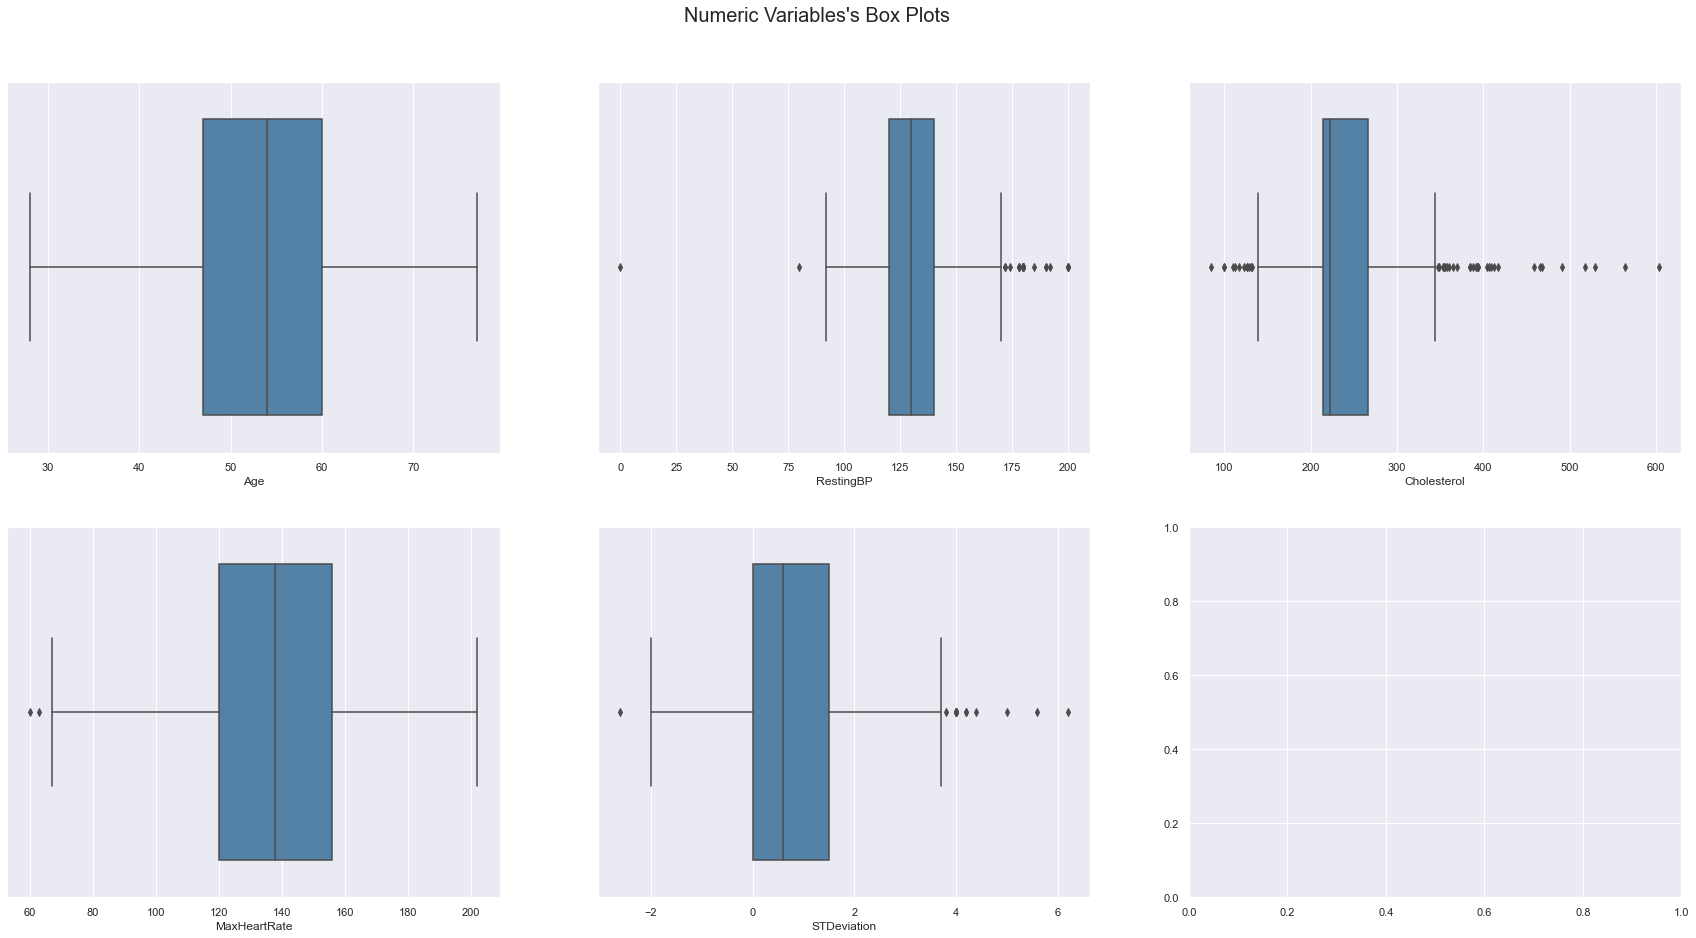

In [575]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(30, 15))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax, color='steelblue')

title = "Numeric Variables's Box Plots"
plt.suptitle(title, y=0.95, fontsize=20)
plt.show()

#### Remoção dos outliers

In [576]:
outliers_filter = ( ((100 < df['Cholesterol']) & (df['Cholesterol'] < 350))
                    & ((75 < df['RestingBP']) & (df['RestingBP'] < 175))
                    & (df['STDeviation'] < 4))
df_no_outliers = df[outliers_filter].copy()
df_no_outliers.shape

(854, 16)

In [577]:
print('Percentage of data kept after removing outliers:', np.round(df_no_outliers.shape[0] / df.shape[0], 4)*100, '%')
print('Percentage of data removed:', np.round((1-(df_no_outliers.shape[0] / df.shape[0]))*100, 4), '%')

df = df_no_outliers

Percentage of data kept after removing outliers: 93.03 %
Percentage of data removed: 6.9717 %


Verifica-se a existência de alguns outliers nas variaveis numéricas, como, por exemplo, nos dados da pressão sanguinea
e niveis de colestrol, contudo, a existência destes “outliars” pode estar correlacionada com a presença
de doença do coração, isto é, pode ser um fator que contribui para esta se manifestar.

Assim, apenas outliears que representavam dados irrealistas de acordo com o significado clinico da variável,
foram removidos.

### Análise sobre ter doença cardiovascular

#### Distribuição por género

In [578]:
df['Gender'].value_counts(normalize=True)

1    0.796253
0    0.203747
Name: Gender, dtype: float64

Verifica-se que aproximadamente 4 em 5 individous neste conjunto de dados são homems

##### Distribuição por idades

<AxesSubplot:>

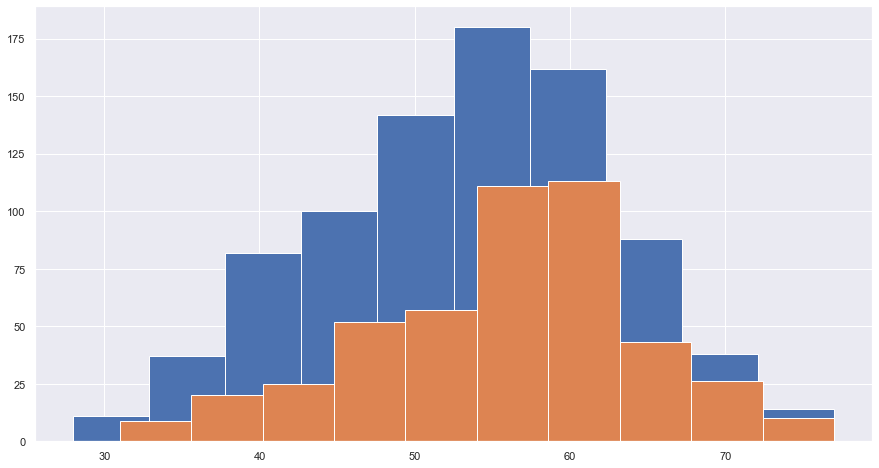

In [579]:
df_heart_disease = df[df.HeartDisease.apply(lambda x: x == 1)]
df['Age'].hist()
df_heart_disease['Age'].hist()

Ao analisar a distribuição de idades constata-se que a maior parte dos individuos tem entre 50 e 65 anos.

Ao comparar-se a distribuição das idades com as idades em que individuos sofrem de
doenças do coração verifica-se que esta é mais comum na faixa etária entre os 55 e 65 anos

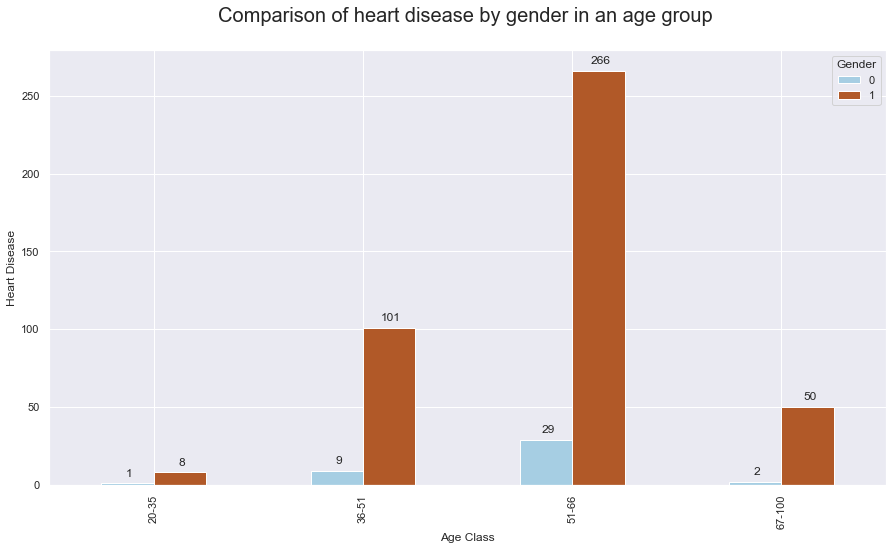

In [580]:
counts = df_heart_disease.groupby(['AgeClass', 'Gender']).Age.count().unstack()

ax = counts.plot(kind='bar',stacked = False, colormap = 'Paired')

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

ax.set_xticklabels(['20-35','36-51','51-66','67-100'])
plt.xlabel ('Age Class')
plt.ylabel ('Heart Disease')
plt.title('Comparison of heart disease by gender in an age group \n',fontsize=20)
plt.show()

Filtrando os dados por individuos apenas com doença de coração, e tendo em conta a desproporção do género neste dataset
verifica-se que homems entre os 51 e os 66 anos sofrem ligeiramente mais com esta doença.

##### Dores no peito

Dores no peito quando a praticar exercício físico, sob stress ou até em repouso são dos principais motivadores que levam
individuos a procurar ajuda médica para despistar possiveis problemas, assim é importante ver a relação que estes
indicadores podem ter na possibilidade de existir um problema mais sério.

In [581]:

# ChestPainType: ASY -> 0 | ATA -> 1 | NAP -> 2 | TA -> 3
# ExerciseAngina: N -> 0 | Y -> 1

df_with_pain = (df['ChestPainType'] > 0)
df_pain_exercising = (df['ExerciseAngina'] == 1)

In [582]:
df[df_pain_exercising]['HeartDisease'].value_counts(normalize=True)

1    0.85119
0    0.14881
Name: HeartDisease, dtype: float64

In [583]:
df[df_pain_exercising & df_with_pain]['HeartDisease'].value_counts(normalize=True)

1    0.657143
0    0.342857
Name: HeartDisease, dtype: float64

In [584]:
print(df[df_with_pain]['ExerciseAngina'].value_counts(normalize=True), '\n')
print(df[df_pain_exercising]['ChestPainType'].value_counts(normalize=True))

0    0.826733
1    0.173267
Name: ExerciseAngina, dtype: float64 

0    0.791667
2    0.145833
1    0.044643
3    0.017857
Name: ChestPainType, dtype: float64


Verifica-se que 85% dos pacientes que reportam dores ao fazer exercício sofrem de doenças cardiovasculares, mas
pacientes que reportam essas dores e dores no peito no geral, apenas 65% tem doenças cardiovasculares.

Assim, dores no peito ao fazer exercício tem uma grande correlação com ter doenças cardiovasculares, já a
presença de dores no peito e dores ao fazer exercício não demonstrou ter correlação alguma.

#### Dados clínicos de despiste

Antes de se recorrer a procedimentos mais invasivos, apurar o nível de **colestrol**, **pressão sanguinea**,
**açucar no sangue** ou até fazer um eletrocardiograma (ECG), são os passos mais comuns para uma análise geral do quadro clínico do paciente.

In [585]:
high_cholesterol = df['CholesterolClass'] == "High"
high_BP = df['RestingBPClass'] == "High"
has_diabetes = df['Diabetes'] == 1

df_1 = df[high_cholesterol & high_BP]
print(df_1['HeartDisease'].value_counts(normalize=True), '\n')

print(df[high_cholesterol & high_BP & has_diabetes].shape)

1    0.728477
0    0.271523
Name: HeartDisease, dtype: float64 

(48, 16)


In [586]:
df[high_cholesterol & high_BP & has_diabetes]['HeartDisease'].value_counts(normalize=True)

1    0.854167
0    0.145833
Name: HeartDisease, dtype: float64

Aqui é possivel ver que 85% dos pacientes que apresentam uma combinação de colestrol, pressão sanguinea e diabetes têm
doenças cardiovasculares. Que são todos indices que se sabe, que contribuem para que este tipo de doenças ocorram, uma
vez que demonstram que o sistema cardiovascular de um individuo se encontra sobre carregado e em esforço.

#### Dores no peito e niveis de risco de dados clínicos

Uma vez que dores no peito durante o exercício apresenta grande correlação com a existência de doenças cardiovasculares
tal como como niveis de risco de dados clínicos, é interessante ver se pacientes com estes dados de risco, reportaram as
dores de peito

In [587]:
print(df[high_cholesterol & high_BP & has_diabetes]['ExerciseAngina'].value_counts(normalize=True))

print(df[high_cholesterol & high_BP & has_diabetes & df_pain_exercising]['HeartDisease'].value_counts(normalize=True))

1    0.583333
0    0.416667
Name: ExerciseAngina, dtype: float64
1    0.928571
0    0.071429
Name: HeartDisease, dtype: float64


Como esperado 58% dos pacientes com niveis de risco apresenta dores no peito ao exercitar-se e 93% desses sofre de
doenças cardiovasculares


#### Eletrocardiograma (ECG)

Contudo nem sempre os indicadores são assim tão assim tão expressiveis, e os médicos podem ter necessidade de recorrer a
um eletrocardiograma (ECG) para despistar problemas.

In [588]:
# RestingECG: LVH -> 0 | Normal -> 1 | ST -> 2
normal_ecg = df['RestingECG'] == 1
st_ecg = df['RestingECG'] == 2
lvh_ecg = df['RestingECG'] == 0

print(df[normal_ecg]['HeartDisease'].value_counts(normalize=True), '\n')
print(df[lvh_ecg]['HeartDisease'].value_counts(normalize=True), '\n')
print(df[st_ecg]['HeartDisease'].value_counts(normalize=True))

1    0.506744
0    0.493256
Name: HeartDisease, dtype: float64 

1    0.563953
0    0.436047
Name: HeartDisease, dtype: float64 

1    0.650307
0    0.349693
Name: HeartDisease, dtype: float64


<AxesSubplot:>

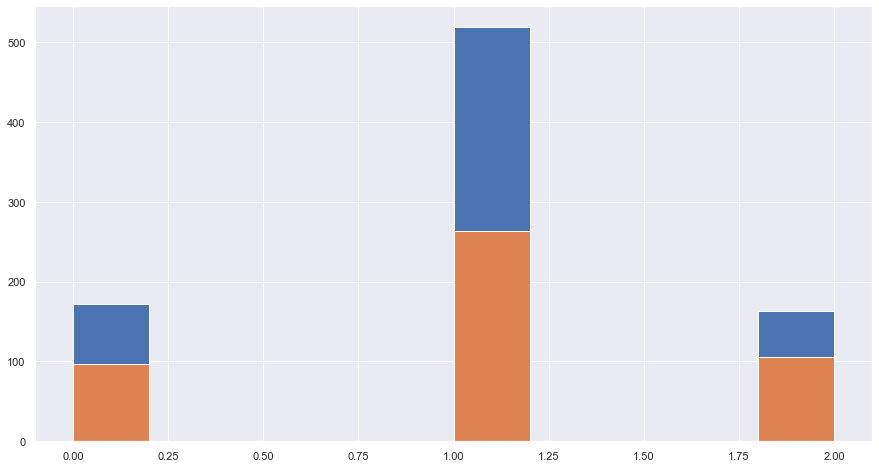

In [589]:
df['RestingECG'].hist()
df_heart_disease['RestingECG'].hist()

Parece que um eletrocardiograma com resultado "normal" não é uma segurança de que o paciente está livre de problemas,
contudo também não garante o contrário.

In [590]:
# ST_Slope: Down -> 0 | Flat -> 1 | Up -> 2
up_slope = df['ST_Slope'] == 2
down_slope = df['ST_Slope'] == 0
st_deviation_down = df['STDeviation'] > 0

print(df[down_slope & st_deviation_down]['HeartDisease'].value_counts())

1    37
0    11
Name: HeartDisease, dtype: int64


<AxesSubplot:>

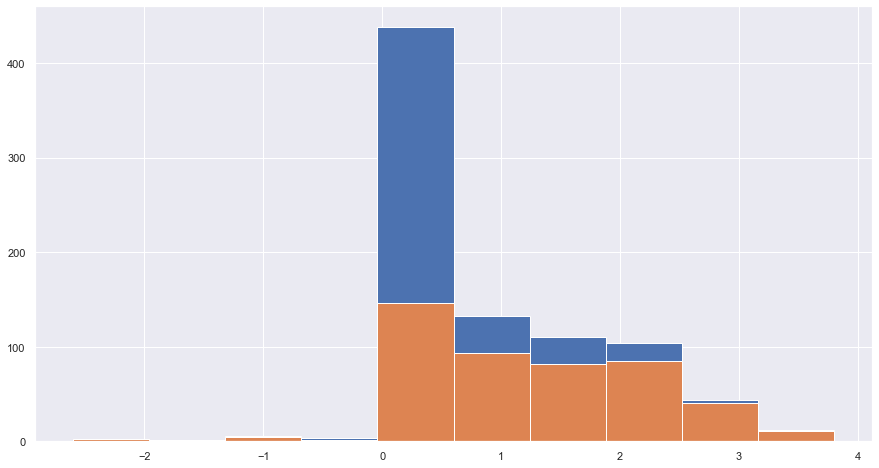

In [591]:
df['STDeviation'].hist()
df_heart_disease['STDeviation'].hist()

Parece que quanto maior o valor de ST-Deviation maior a probabilidade ter doença cardiovascular

#### ST elevation in man and women

<AxesSubplot:>

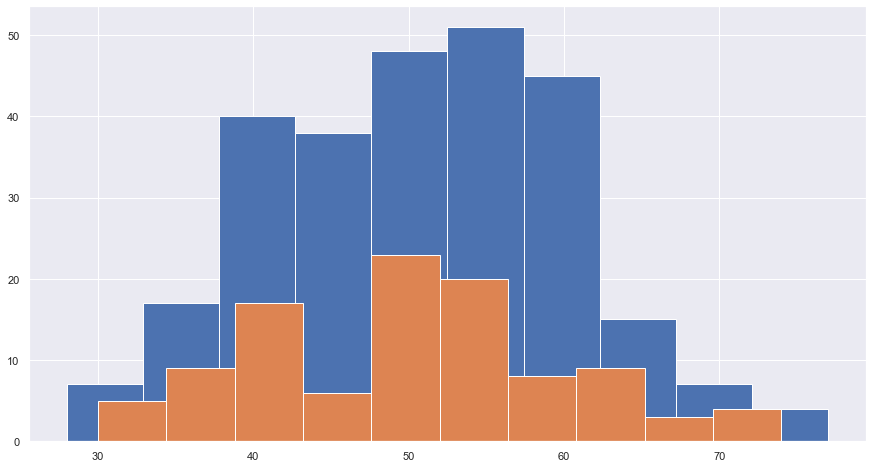

In [592]:
# Gender: M -> 1 | F -> 0
df[up_slope & (df['Gender'] == 1)]['Age'].hist()
df[up_slope & (df['Gender'] == 0)]['Age'].hist()

Segundo, https://www.ncbi.nlm.nih.gov/books/NBK459364/,
ST elevation parecer ser mais predominante em homems jovens e adultos de meia-idade em relação
às mulheres e segundo o gráfico a cima os dados confirmam estas afirmações.


#### Max hear rate

<AxesSubplot:>

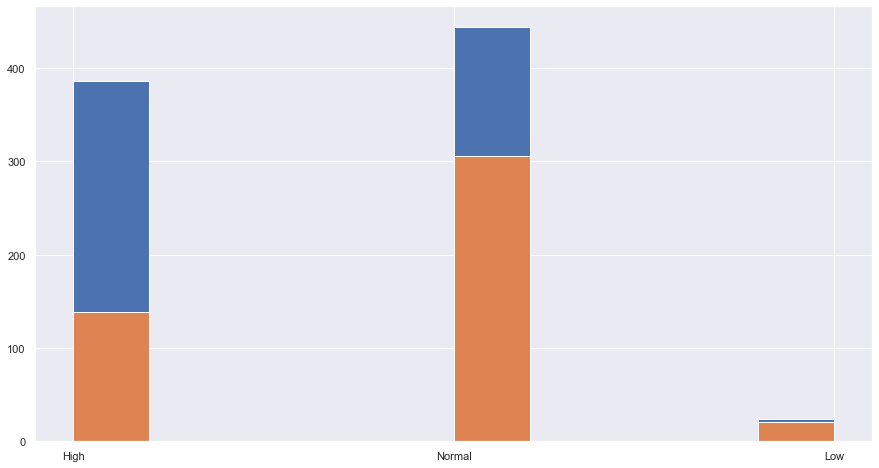

In [593]:
high_max_hr = df['MaxHeartRateClass'] == "High"
normal_max_hr = df['MaxHeartRateClass'] == "Normal"

df['MaxHeartRateClass'].hist()
df_heart_disease['MaxHeartRateClass'].hist()


## Machine learning

In [594]:
df['HeartDisease'].value_counts(normalize=True)

1    0.545667
0    0.454333
Name: HeartDisease, dtype: float64

O dataset aparenta ser quase balanceado neste aspeto, uma vez que existem quase tantos casos com
doença de coração como sem.

### Model Pipeline

In [641]:
def classify(model, inputs, targets):
    X_train, X_test, y_train, y_test = train_test_split(inputs,targets,test_size=0.8, random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(accuracy_score(y_test, y_pred),4)

#### Normalização dos dados

In [596]:
def standardScaler(features):
    scaler = StandardScaler()
    scaler.fit(features)
    return scaler.transform(features)

def minMaxScaler(features):
    sc = MinMaxScaler()
    return sc.fit_transform(features)

### Model comparison

In [643]:
inputs = df.drop(['HeartDisease', 'CholesterolClass', 'RestingBPClass', 'MaxHeartRateClass'], axis=1)
targets = df['HeartDisease']

svm = SVC(gamma='scale')
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=0)

models = [svm, knn, rf]

for model in models:
    acc = classify(model=model, inputs=minMaxScaler(inputs), targets=targets)
    print (f'model : {model} and  accuracy score is : {acc}')

model : SVC() and  accuracy score is : 0.8187
model : KNeighborsClassifier() and  accuracy score is : 0.8099
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8289


Looks like RandomForest has a better performance, so that will be the selected one

### Improved Feature Selection

Agora que temos uma baseline definida, vamos tentar melhorar o modelo, fazendo uma melhor feature selection

#### Filter by variance

Variaveis com pouca variedade geralmente não são boas para modelos efeitos de previsão, por isso
podem ser descartadas.

In [ ]:
df_features = df.drop("HeartDisease",axis = 1)
df_features.var()

#### Filter by correlation

In [ ]:
abs(df.corr()['HeartDisease'])

Este tipo da análise permite ver que apesar de a coluna 'ST_Slope' ter baixa variância, é a que apresenta maior
correlação com a existência de doença do coração.

De modo a analisar a precisão de acordo com o nivel de correlação escolhido, corre-se o mesmo modelo para diferentes
niveis de correlação.

In [ ]:
corrs = [0.1, 0.2, 0.3, 0.4, 0.5]

best_corr = 0
max_res = 0
for corr in corrs:
    high_corr_cols = abs(df.corr()['HeartDisease'][abs(df.corr()['HeartDisease'])>corr].drop('HeartDisease')).index.tolist()
    df_features = df[high_corr_cols]
    targets = df["HeartDisease"]
    inputs = df_features
    res = classify(model=RandomForestClassifier(), features=inputs, targets=targets)
    if res > max_res:
        max_res = res
        best_corr = corr
    print('min correlation:',corr,'- precision:',res,'\n')

Model result presentation ideas

In [600]:
#y_hat = rfc.predict(x_test)
#final_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_hat})
#final_result

Precisão final

In [601]:
#print(f"Acuraccy: {round(rfc.score(x_test,y_test),2)*100}%")

##### Niveis de colestrol

In [602]:
#df['CholesterolClass'].value_counts(normalize=True)

In [603]:
#plt.hist([df['CholesterolClass'], df_heart_disease['CholesterolClass']], color=['r','b'], alpha=0.5)

In [604]:
# Percentage of cholesterol_type in individuals with heart disease
#df_heart_disease['CholesterolClass'].value_counts() / df['CholesterolClass'].value_counts()

Comparando a ocorrência de doença de coração com os niveis de colestrol, é possivel verificar
que 50% dos individuos com colestrol alto sofrem da mesma e que 88%
dos que apresentam niveis baixos também.

Esta analise demonstra também que em individuos com niveis normais de colestrol, a presença da doença
é de 38%, contudo, é importante notar, que 83% dos individuos neste dataset apresenta niveis
elevados de colestrol, muito em parte devido a ter-se assumido para os 18% dos dados que tinham os niveis colestrol em
falta, que seria atribuido o valor da mediana (289).

#### Pressão Sanguinea

In [605]:
#print('Total\n',df['RestingBPClass'].value_counts(normalize=True), '\n')
#print('Heart Disease\n',df_heart_disease['RestingBPClass'].value_counts())

In [606]:
#plt.hist([df['RestingBPClass'], df_heart_disease['RestingBPClass']], color=['r','b'], alpha=0.5)

In [607]:
# Percentage of RestingBPClass in individuals with heart disease
#df_heart_disease['RestingBPClass'].value_counts() / df['RestingBPClass'].value_counts()

Comparando a ocorrência de doença de coração com os niveis de pressão sanguinea, é possivel verificar
que 68% dos individuos com pressão alta sofrem da mesma. Devido a este dataset não conter nenhuns casos de pressão
baixa, não é possivel tirar conclusões sobre esta.

Esta analise demonstra também que em individuos com niveis normais de pressão sanguinea, a presença da doença
é de 51%, contudo, é importante notar, que estes são dados sobre pressão sanguinea em repouso, que para um quadro
clinico, podem tirar grande disparidade da pressão sanguinea quando um individuo está em esforço.

##### Nivel de açucar no sangue em jejum / Diabetes

In [608]:
# 0 -> no diabetes | 1 -> has diabetes
#df['Diabetes'].value_counts(normalize=True)

In [609]:
#plt.hist([df['Diabetes'], df_heart_disease['Diabetes']], color=['r','b'], alpha=0.5)

In [610]:
# Percentage of cholesterol_type in individuals with heart disease
#df_heart_disease['Diabetes'].value_counts() / df['Diabetes'].value_counts()